Get List of Protein ID's

In [3]:
# Map Protein IDs to names
import pandas as pd
import numpy as np

# Define the path to the CSV file
CSV_PATH = "/home/lcornelis/code/proteo/proteo/datasets/data/ALLFTD_dataset_for_nina_louisa.csv"
def get_protein_ids():
        print("Loading data from:", CSV_PATH)
        csv_data = pd.read_csv(CSV_PATH)
        has_plasma = csv_data.iloc[:, 9].astype(int)
        has_plasma = has_plasma == 1  # Converting from indices to boolean
        nfl = csv_data.loc[has_plasma, csv_data.columns[8]].astype(float)
        nfl_mask = ~np.isnan(nfl)

        # Extract the protein column names
        plasma_protein_cols = csv_data.columns[10 : 7299]
    
        # Extract and convert the plasma_protein values for rows where has_plasma is True and nfl is not NaN
        plasma_protein = csv_data.loc[has_plasma, plasma_protein_cols][nfl_mask].astype(float)

        protein_column_names = plasma_protein.columns
        
        return protein_column_names

protein_ids = get_protein_ids()
print(len(protein_ids))

Loading data from: /home/lcornelis/code/proteo/proteo/datasets/data/ALLFTD_dataset_for_nina_louisa.csv
7289


Create Explainer and run on every person

conv1 is:GATConv(1, 8, heads=4)
conv2 is:GATConv(32, 16, heads=3)
89
n_nodes = 7289
Number of patients 89
Counter({'MB21D2|Q8IYB1|PLASMA': 15, 'CSTB|P04080|PLASMA': 15, 'B2M|P61769^SL000283@seq.3485.28|PLASMA': 13, 'NOG|Q13253^SL004683@seq.5846.24|PLASMA': 13, 'ZNF10|P21506|PLASMA': 13, 'ANG|P03950|PLASMA': 13, 'CABLES2|Q9BTV7|PLASMA': 13, 'STAMBPL1|Q96FJ0|PLASMA': 12, 'CXCL11|O14625^SL003326@seq.3038.9|PLASMA': 12, 'CRIP2|P52943|PLASMA': 12, 'BSG|P35613|PLASMA': 12, 'CDCP1|Q9H5V8^SL017488@seq.6565.68|PLASMA': 12, 'HBZ|P02008|PLASMA': 12, 'MAP4K1|Q92918|PLASMA': 12, 'CD320|Q9NPF0|PLASMA': 11, 'CFD|P00746^SL003327@seq.2946.52|PLASMA': 11, 'RAB38|P57729|PLASMA': 11, 'SMTN|P53814|PLASMA': 11, 'CGB2|Q6NT52|PLASMA': 11, 'IGFALS|P35858|PLASMA': 11, 'MMP20|O60882^SL012374@seq.6374.7|PLASMA': 11, 'PCSK1N|Q9UHG2|PLASMA': 11, 'NISCH|Q9Y2I1|PLASMA': 11, 'SNX8|Q9Y5X2|PLASMA': 11, 'CXCL16|Q9H2A7|PLASMA': 11, 'MRFAP1L1|Q96HT8|PLASMA': 11, 'CDH1|P12830^SL000055@seq.2501.51|PLASMA': 11, 'CLPSL1|A2RUU4

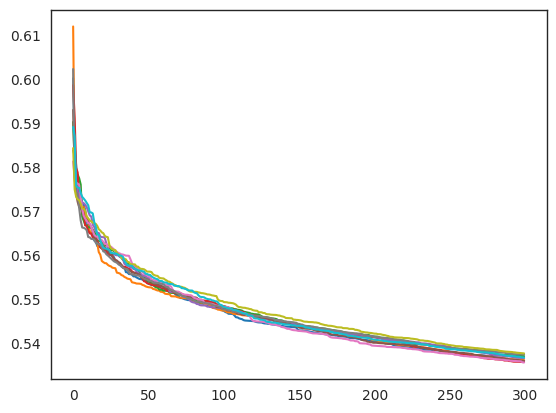

In [4]:
# Compute explainer for each person in the dataset
import os
import torch
import torch_geometric
from torch_geometric.explain import GNNExplainer, Explainer
from main import Proteo, AttrDict
from proteo.datasets.ftd import ROOT_DIR, FTDDataset
from config_utils import CONFIG_FILE, read_config_from_file
from models.gat_v4 import GATv4
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter



#Load model checkpoint
module = Proteo.load_from_checkpoint("/home/lcornelis/code/proteo/proteo/checkpoints/ckpt14-05-2024epoch=41.ckpt")

# Load datasets
root = os.path.join(ROOT_DIR, "data", "ftd")
config = read_config_from_file(CONFIG_FILE)
model_parameters = getattr(config, config.model)
model_parameters = AttrDict(model_parameters)
test_dataset = FTDDataset(root, "test", config)
train_dataset = FTDDataset(root, "train", config)

# Choose dataset
dataset = test_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Construct Explainer and set parameters
explainer = Explainer(
model=module.model.to(device),
algorithm=GNNExplainer(epochs=5),
explanation_type='model',
model_config=dict(
    mode='regression',
    task_level='graph',  # Explain why the model predicts a certain property or label for the entire graph (nodes + edges)
    return_type='raw'
),
node_mask_type='object', # Generate masks that indicate the importance of individual node features
edge_mask_type=None,
threshold_config=dict(
    threshold_type='topk',
    value=300,
),
)



# Run explainer on each person in dataset
i = 0 
all_proteins = []
print(len(dataset))
n_nodes = len(dataset[0].x)
print(f"n_nodes = {n_nodes}")
# Initialize sum_node_importance as a dictionary with protein_ids as keys
sum_node_importance = {protein_id: 0 for protein_id in protein_ids}

for data in dataset:
    data_attributes = data.keys
    # Ensure data.x and data.edge_index are tensors
    if not isinstance(data.x, torch.Tensor) or not isinstance(data.edge_index, torch.Tensor):
        raise TypeError("data.x and data.edge_index must be torch.Tensor")
    #print(f'Batch actual attributes: {data_attributes}')
    explanation = explainer(
        data.x,
        data.edge_index,
        data=data,
        target=None,
        index=None
    )
    #print(f'Generated explanations in {explanation.available_explanations}')
    # Node_importance is of format [[0], [0],[0],...,[.5]] with length equal to the number of nodes
    node_importance = explanation.node_mask.cpu().detach().numpy()
    if i < 10:
        #Note: this is not going to show the same proteins, it will just show the top 300 for 10 first people
        plt.plot(sorted(node_importance, reverse=True)[:300])

    # Find row indices of non-zero elements in node_importance
    indv_important_proteins_indices = np.nonzero(node_importance)[0]
    indv_important_proteins = protein_ids[indv_important_proteins_indices]
    
    all_proteins.append(indv_important_proteins) #array holding all the important proteins for each person

    # Update sum_node_importance dictionary using protein_ids as keys
    for idx, importance in enumerate(node_importance):
        protein_id = protein_ids[idx]
        sum_node_importance[protein_id] += importance[0]
        
    i += 1

print("Number of patients", i)
# Flatten the list of lists into a single list
full_count = [item for sublist in all_proteins for item in sublist]

# Use Counter to count the occurrences of each element
protein_count = Counter(full_count)
print(protein_count)
print(len(protein_count))


Plot Average Importance of Top Proteins

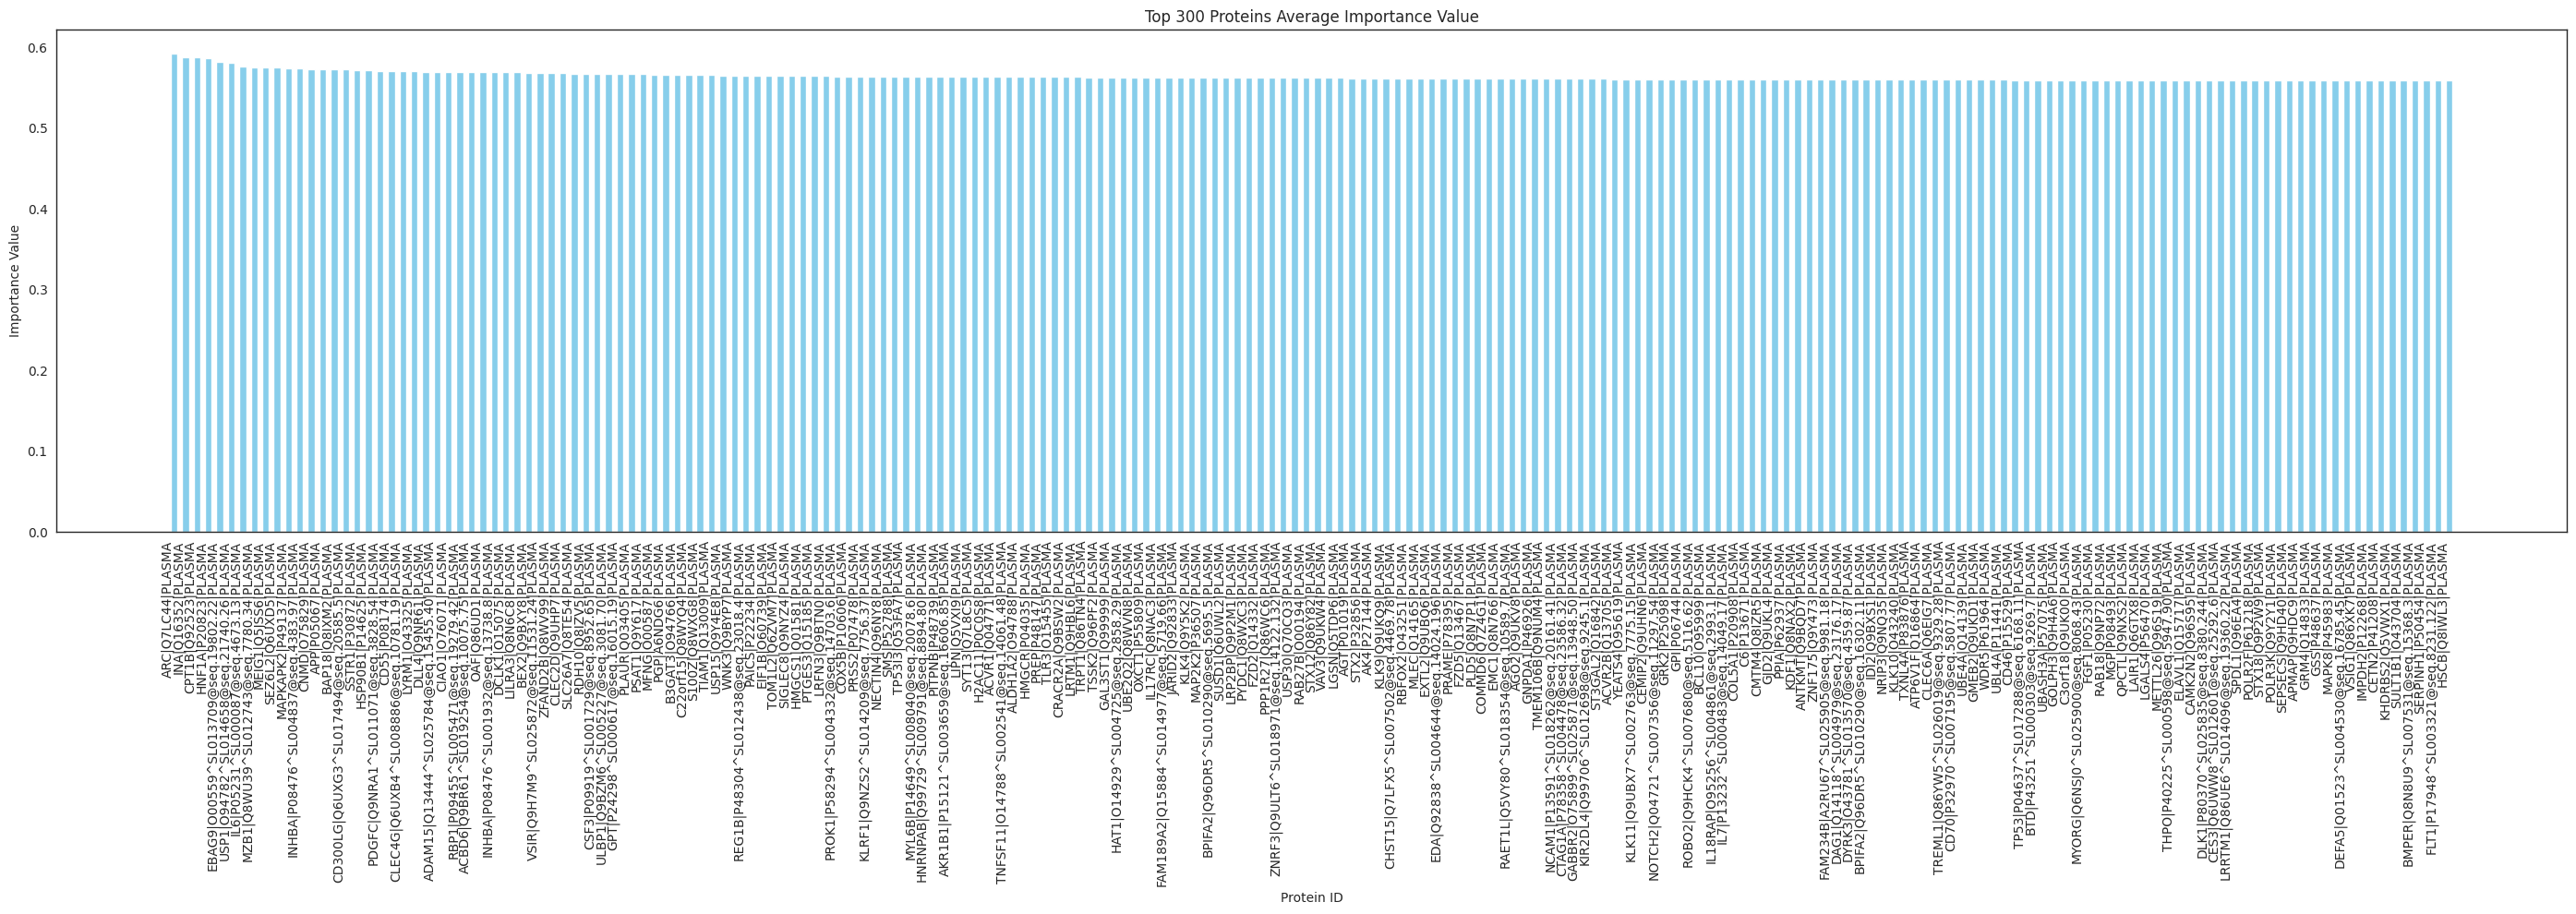

In [5]:
def divide_dict_values(dict1, dict2):
    result = {}
    for key in dict1:
        if key in dict2:
            if dict1[key] != 0:  # Avoid division by zero
                result[key] = dict2[key] / dict1[key]
            else:
                result[key] = None  # or handle division by zero as needed
    return result

sum_node_importance_avg = divide_dict_values(protein_count, sum_node_importance)

sorted_items = sorted(sum_node_importance_avg.items(), key=lambda x: x[1], reverse=True)
# Get the first 300 items (or less if there are fewer than 300 items)
top_300_items = sorted_items[:200]


def plot_a_dictionary(dict, title, x_label, y_label):
    # Separate the items into x and y components for plotting
    keys = [item[0] for item in dict]
    values = [item[1] for item in dict] # Value is a list of one object

    # Plot the data
    plt.figure(figsize=(28, 10))
    bar_width = 0.6
    plt.bar(keys, values, color='skyblue', width=bar_width)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90, ha='right')  # Rotate x-ticks for better readability
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    #plt.gca().invert_xaxis()  # Invert y-axis to have the highest values on top
    plt.show()


plot_a_dictionary(top_300_items, 'Top 300 Proteins Average Importance Value', 'Protein ID', 'Importance Value')


Plot counts per protein

<class 'collections.Counter'>


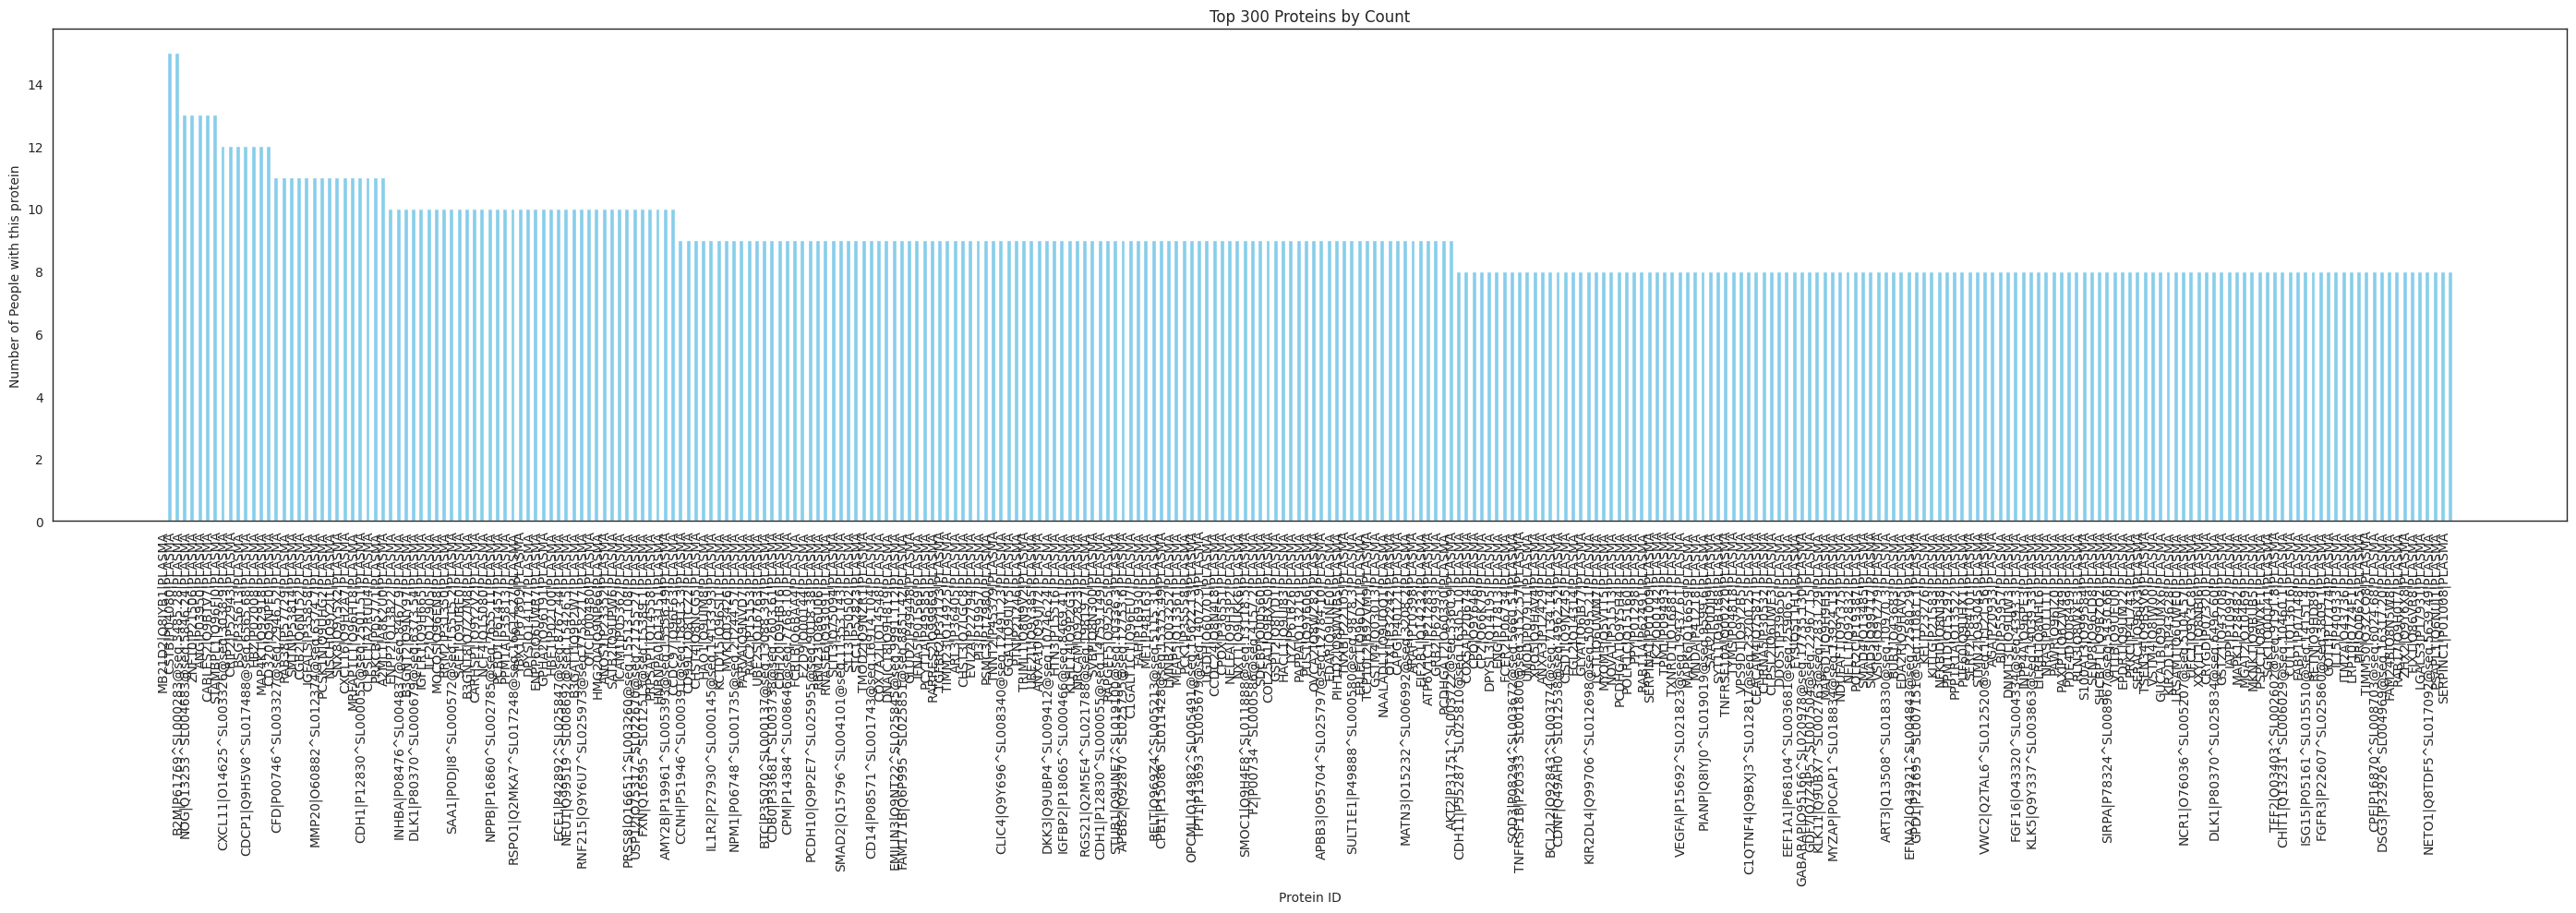

In [6]:
import matplotlib.pyplot as plt

print(type(protein_count))
sorted_proteins = sorted(protein_count.items(), key=lambda x: x[1], reverse=True)

top_300_count = sorted_proteins[:300]

plot_a_dictionary(top_300_count, 'Top 300 Proteins by Count', 'Protein ID', 'Number of People with this protein')

Find WGCNA Clusters

(441, 7289)
Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  6137
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.628611 -0.930622       0.774962  586.547051  374.357936   
1       2   0.73949 -0.839783       0.956489  239.773855   71.531197   
2       3  0.817364 -0.799865       0.968549  139.649918   17.753762   
3       4  0.874339 -0.782453       0.968892   94.265611    5.458057   
4       5  0.908199 -0.784746        0.95725   68.560268    1.997544   
5       6   0.92714 -0.802024       0.944771   52.161658    0.843222   
6       7  0.942585  -0.82067       0.943414   40.920431    0.378143   
7       8  0.938895 -0.843951        0.92422   32.833747    0.183264   
8       9   0.93418 -0.863399       0.915385     26.8097    0.089957   
9      10  0.922563 -0.885622       0.903574   22.200989     0.04667   
10     11  0.907874 -0.912621       0.894529    18.59975     0.02322   
11     13  0.873799 -

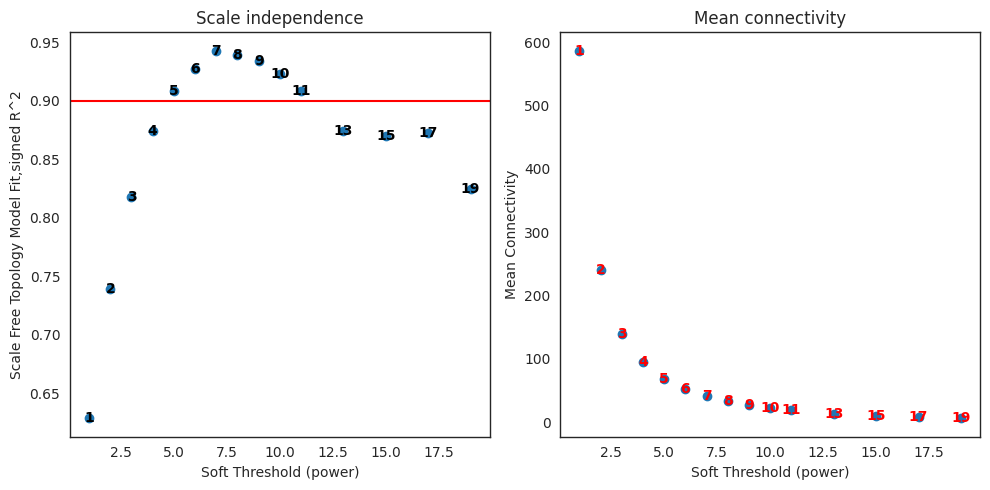

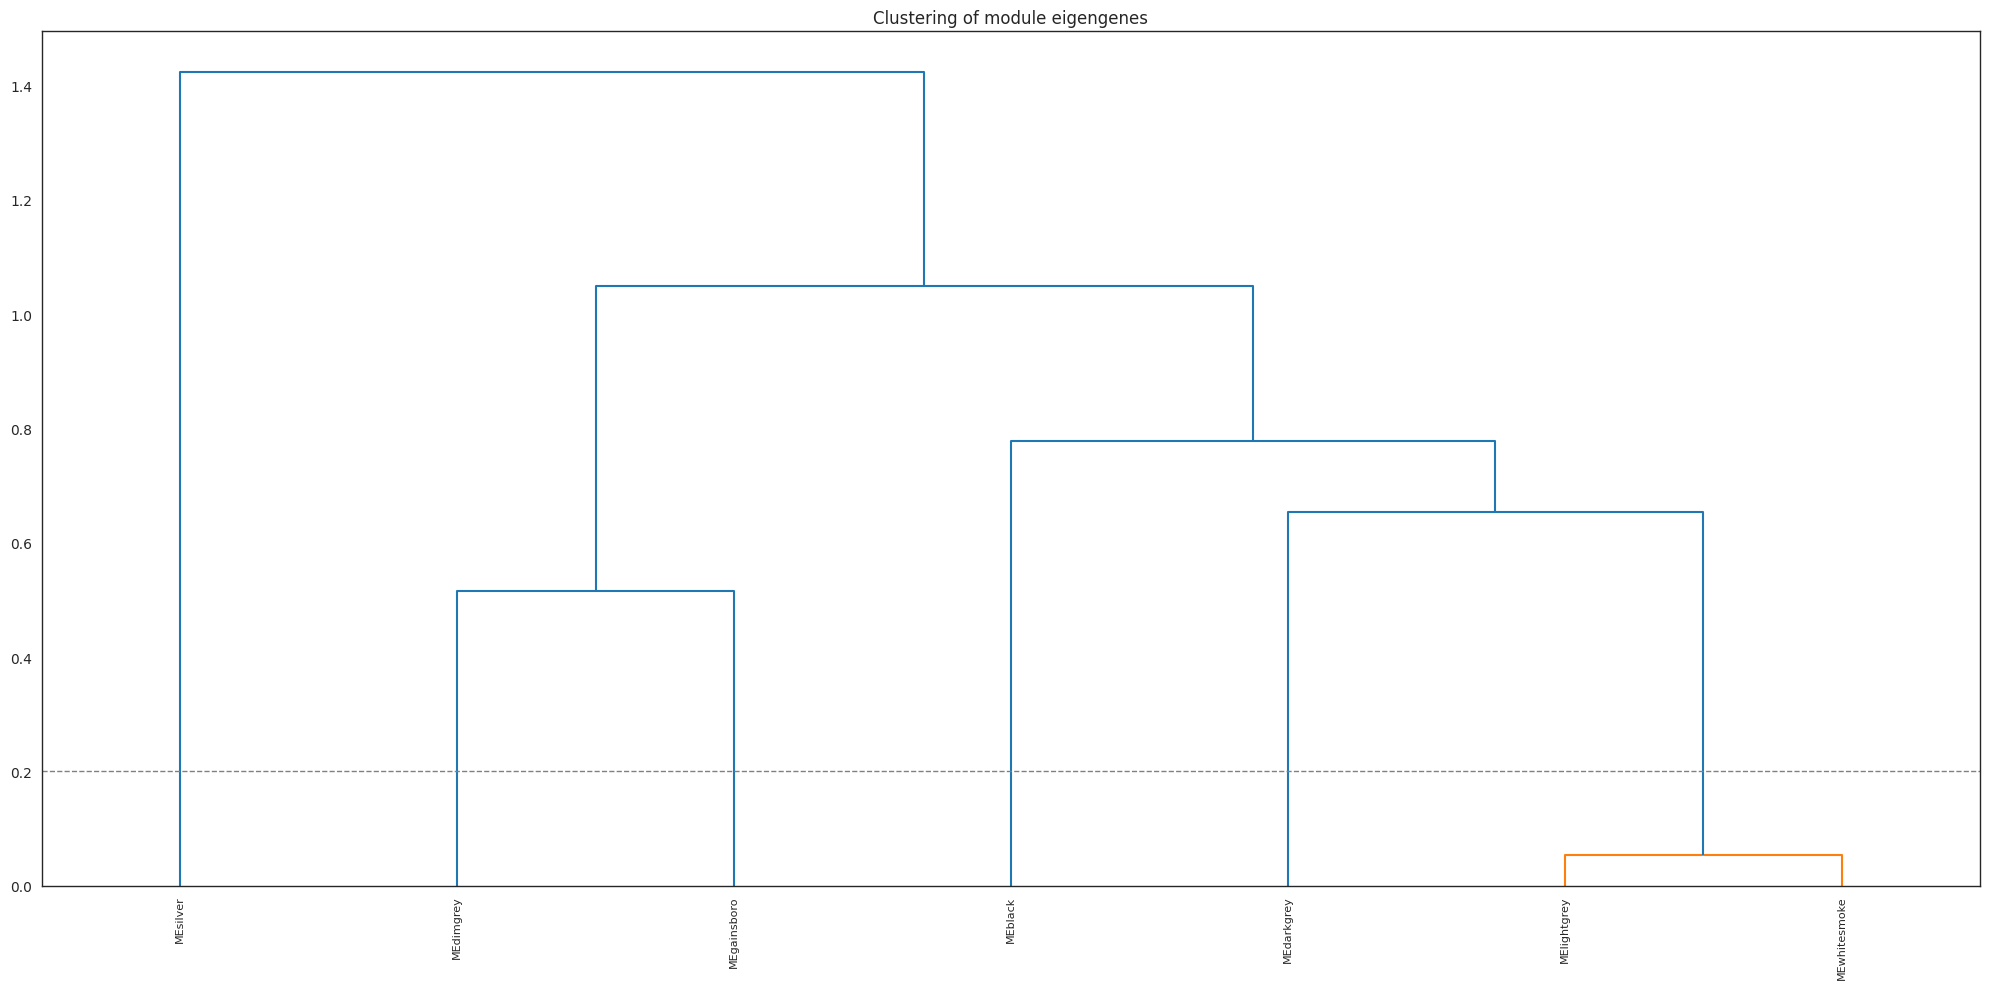

In [32]:
import pandas as pd
import PyWGCNA
from PyWGCNA import WGCNA

# Step 1: Load your data
# Assuming you have a CSV file with rows as proteins and columns as samples
csv_data = pd.read_csv(CSV_PATH)
has_plasma = csv_data.iloc[:, 9].astype(int)
has_plasma = has_plasma == 1  # Converting from indices to boolean
nfl = csv_data.loc[has_plasma, csv_data.columns[8]].astype(float)
nfl_mask = ~np.isnan(nfl)
# Extract the protein column names
plasma_protein_cols = csv_data.columns[10 : 7299]
    
# Extract and convert the plasma_protein values for rows where has_plasma is True and nfl is not NaN
plasma_protein = csv_data.loc[has_plasma, plasma_protein_cols][nfl_mask].astype(float)
print(plasma_protein.shape)

# Step 2: Initialize WGCNA object
wgcna = WGCNA(name = "FTD_Dataset", species = "Human", geneExp= plasma_protein)

wgcna.findModules()

# Constructing dict of module names and the proteins in each module
module_names = wgcna.getModuleName()
module_dict = {}
for module in module_names:
    module_proteins = wgcna.getGeneModule(module)
    module_dict[module] = module_proteins



Plot counts per WGCNA Cluster

Total count protein: 26700
Total count module: 26700


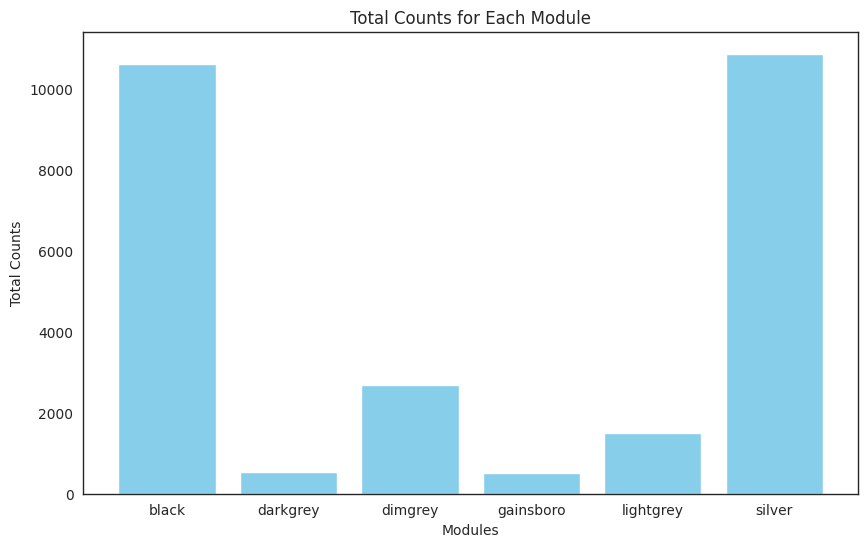

In [31]:
# Constructing dict of module names and the proteins in each module
wgcna_modules_dict= {}

for module in module_dict:
    wgcna_modules_dict[module] = module_dict[module][module].index

# Step 1: Aggregate the counts for each module
module_counts = {}

# Iterate over the wgcna_module_dict correctly using the Index object
for module, proteins in wgcna_modules_dict.items():  # 'proteins' is actually an Index object
    total_count = 0
    for protein in proteins:  # Iterate directly over the Index object
        if protein in protein_count:
            total_count += protein_count[protein]
    module_counts[module] = total_count


# Sanity check to make sure all proteins were counted
total_count_protein = sum(protein_count.values())
print("Total count protein:", total_count_protein)
total_count_modules = sum(module_counts.values())
print("Total count module:", total_count_modules)



# Step 2: Plot the aggregated counts
module_names = list(module_counts.keys())
total_counts = list(module_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(module_names, total_counts, color='skyblue')
plt.xlabel('Modules')
plt.ylabel('Total Counts')
plt.title('Total Counts for Each Module')
plt.show()



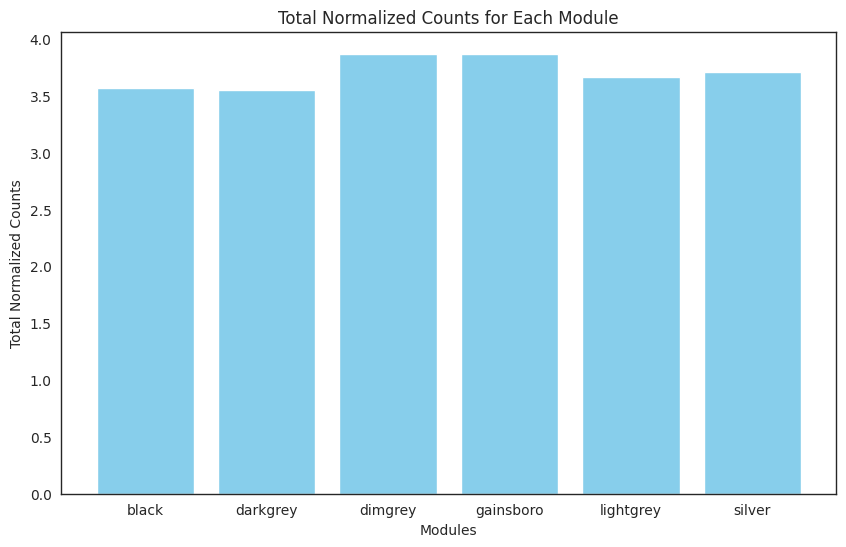

In [38]:
# Normalize by WGCNA module size
protein_counts_per_module = {}

# Iterate over each module in module_dict
for module, proteins in wgcna_modules_dict.items():
    protein_counts_per_module[module] = len(proteins)


normalized_module_counts = divide_dict_values(protein_counts_per_module, module_counts)

# Step 2: Plot the aggregated counts
module_names = list(normalized_module_counts.keys())
total_normalized_counts = list(normalized_module_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(module_names, total_normalized_counts, color='skyblue')
plt.xlabel('Modules')
plt.ylabel('Total Normalized Counts')
plt.title('Total Normalized Counts for Each Module')
plt.show()

Plot average importance per WGCNA cluster

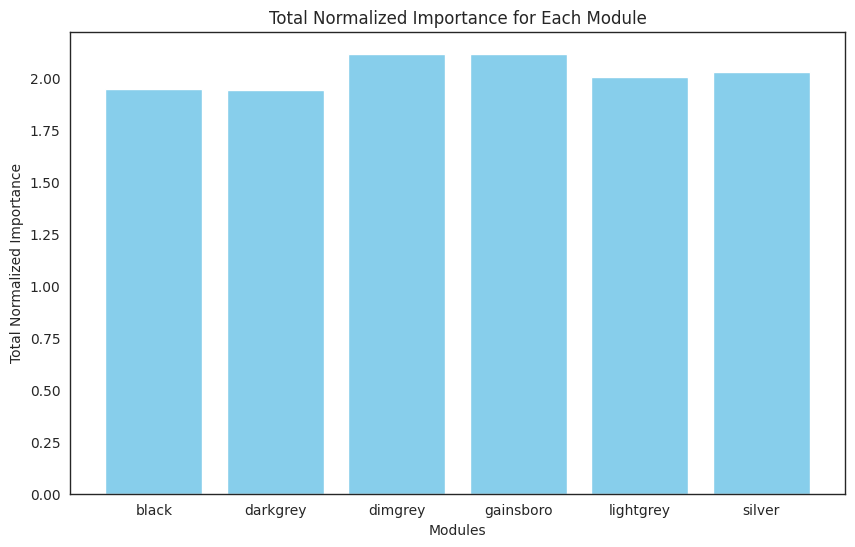

In [39]:
# Step 1: Aggregate the counts for each module
module_importance = {}

# Iterate over the wgcna_module_dict correctly using the Index object
for module, proteins in wgcna_modules_dict.items():  # 'proteins' is actually an Index object
    total_importance = 0
    for protein in proteins:  # Iterate directly over the Index object
        if protein in sum_node_importance:
            total_importance += sum_node_importance[protein]
    module_importance[module] = total_importance

# Normalize by WGCNA module size to get average importance
normalized_module_importance = divide_dict_values(protein_counts_per_module, module_importance)

# Step 2: Plot the aggregated counts
module_names = list(normalized_module_importance.keys())
total_normalized_importance = list(normalized_module_importance.values())

plt.figure(figsize=(10, 6))
plt.bar(module_names, total_normalized_importance, color='skyblue')
plt.xlabel('Modules')
plt.ylabel('Total Normalized Importance')
plt.title('Total Normalized Importance for Each Module')
plt.show()